In [5]:
from simulation import *

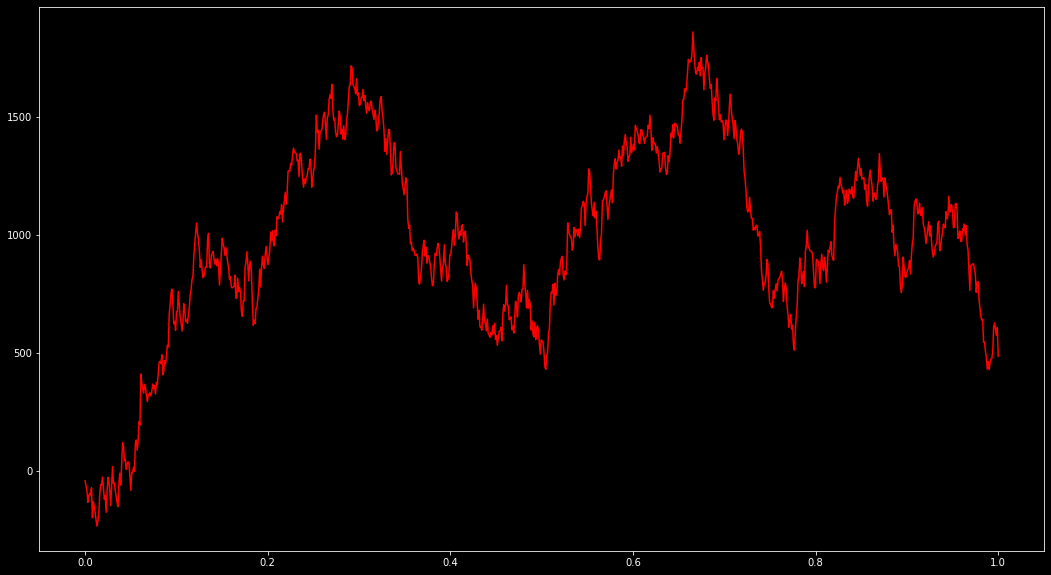

In [7]:
cis = Cov()
matrix = Structure().matrix(cis)
matrix
simu = GaussianProcess(matrix, cis)
gp = simu.simulate_gaussian_process()
brm = simu.generateFBM(delta=10, gp=gp)
plt.style.use('dark_background')
plt.figure(figsize=(18, 10))
plt.plot(np.linspace(0, 1, 1000), brm, color='red')